# Fashion-Mnist

This is the second notebook for my project, in which I will try to get the best result I can to classify the Fahion-Mnist Data set

[conclusion](#conclusion)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB      
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier


In [2]:
import warnings
warnings.filterwarnings('ignore')

First lets import the data and see how it looks

In [3]:
df = pd.read_csv("D:\ML_SEM2\\fashion-mnist_train.csv")

In [4]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


After getting the dataset lets split it to the labels and the data itself

In [5]:
labels = df.label.values
labels

array([2, 9, 6, ..., 8, 8, 7], dtype=int64)

In [6]:
data = df.drop(['label'],axis = 1).values
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Reshape data to correct dimensions to see how an image looks like

In [7]:
data_to_show = data.reshape(-1,28,28,1)

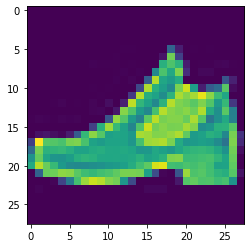

In [8]:
plt.imshow(data_to_show[1]);

lets see how it looks in black and white

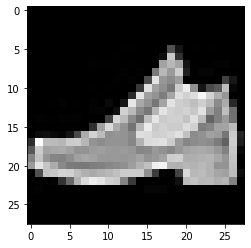

In [9]:
plt.imshow(data_to_show[1],cmap = plt.get_cmap("gray"));

Now lets split the Data and try to get some results from it 

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
data_train, data_test, target_train, target_test = train_test_split(data, labels,test_size = 0.05, random_state=10)

Lets train some week learners before reducing the dimensions.

Also I want to see how much time (in seconds) it takes for each classifier or maybe we can get a bit of a worse result but in a much faster time

Lets make tables to be able to see what impact did running the pca had on the accuracy and training time

In [11]:
model_names = []
before_pca_scores = []
after_pca_scores = []
time_before_pca =[]
time_after_pca = []

# Week learners

first lets train week learners and test our accuracy before PCA using voting, baggin and boosting

In [14]:
knn = KNeighborsClassifier()
n_range = np.arange(100,1001,100)
scores = []
for n in n_range:
    knn.n_neighbors = n
    knn.fit(data_train,target_train)
    pred = knn.predict(data_test)
    scores.append(metrics.accuracy_score(target_test,pred))

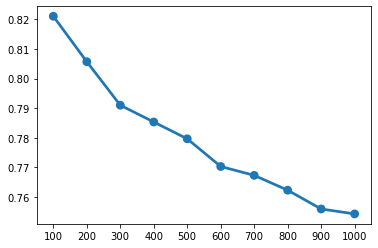

In [15]:
sns.pointplot(x = n_range, y = scores);

As we can see the best knn is with 100 neighbours

In [15]:
knn_before = KNeighborsClassifier(n_neighbors = 100)
gnb_clf = GaussianNB()
LoR_clf = LogisticRegression(random_state=0)
RF_clf = RandomForestClassifier(n_estimators=150, random_state=1)
dtclf = DecisionTreeClassifier(random_state=0, max_depth = 3)

# Voting

we will use our week learners to try and make voting classifiers, both hard and soft, and see what is the best accuracy as well as training times

In [27]:
Soft_voter = VotingClassifier(estimators = [('knn_before',knn_before),('lr',LoR_clf),('decision_tree',dtclf),('gaussian_bayes',gnb_clf),('random_forsts',RF_clf)],n_jobs = -1,voting='soft')
Hard_voter = VotingClassifier(estimators = [('knn_before',knn_before),('lr',LoR_clf),('decision_tree',dtclf),('gaussian_bayes',gnb_clf),('random_forsts',RF_clf)],n_jobs = -1,voting='hard')

In [29]:
for clf in (knn_before,dtclf,gnb_clf,LoR_clf,RF_clf,Soft_voter,Hard_voter):
    start_time = time.time()
    clf.fit(data_train,target_train)
    time_to_train = time.time()-start_time
    pred = clf.predict(data_test)
    score = accuracy_score(target_test,pred)
    name = clf.__class__.__name__
    model_names.append(name)
    before_pca_scores.append(score)
    time_before_pca.append(time_to_train)
    print(name + " score is: %.3f " %(score) + ", time to train: %.2f seconds" %(time_to_train))

KNeighborsClassifier score is: 0.821 , time to train: 31.80 seconds
DecisionTreeClassifier score is: 0.499 , time to train: 7.07 seconds
GaussianNB score is: 0.584 , time to train: 0.90 seconds
LogisticRegression score is: 0.847 , time to train: 23.21 seconds
RandomForestClassifier score is: 0.885 , time to train: 138.54 seconds
VotingClassifier score is: 0.838 , time to train: 150.11 seconds
VotingClassifier score is: 0.850 , time to train: 149.32 seconds


# Bagging

next lets take the logistic regression classifier and try to use bagging with him to get a better result

In [17]:
n_range = np.arange(10,51,10)
bag_scores = []
for n in n_range:
    Bagg_clf = BaggingClassifier(base_estimator=LoR_clf,n_estimators = n)
    Bagg_clf.fit(data_train,target_train)
    pred= Bagg_clf.predict(data_test)
    bag_scores.append(accuracy_score(target_test,pred))

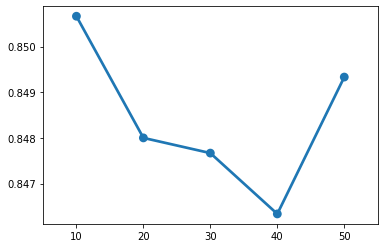

In [18]:
sns.pointplot(x = n_range, y = bag_scores);

as we can see, we got the best result with 10 logistic regression classifiers, so we will use this amount

In [19]:
start_time = time.time()
Bagg_clf_before = BaggingClassifier(base_estimator=LoR_clf,n_estimators = 10)
Bagg_clf_before.fit(data_train,target_train)
time_to_train = time.time() - start_time
pred = Bagg_clf_before.predict(data_test)
score = accuracy_score(target_test,pred)
name = Bagg_clf_before.__class__.__name__
model_names.append(name)
before_pca_scores.append(score)
time_before_pca.append(time_to_train)
print(name + " score is: %.3f " %(score) + ", time to train: %.2f seconds" %(time_to_train))

BaggingClassifier score is: 0.851 , time to train: 167.58 seconds


With just 10 classifiers, we got 85.1% accuracy!

# Boosting

next lets try to use boositing to correct our previous mistakes

In [40]:
#after playing with the variabels a bit, that is the best adaBoostClassifier I got
start_time = time.time()
adaBoost_beofre = AdaBoostClassifier(n_estimators = 150, learning_rate = 0.5)
adaBoost_before.fit(data_train,target_train)
time_to_train = time.time()- start_time
pred = adaBoost_before.predict(data_test)
score = metrics.accuracy_score(target_test,pred)
name = adaBoost_before.__class__.__name__
model_names.append(name)
before_pca_scores.append(score)
time_before_pca.append(time_to_train)
print(name + " score is: %.3f " %(score) + ", time to train: %.2f seconds" %(time_to_train))

AdaBoostClassifier score is: 0.533 , time to train: 422.34 seconds


Next lets check another version of boosting, gradient boosting

In [41]:
start_time = time.time()
gboost_before = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1, max_depth = 3)
gboost_before.fit(data_train,target_train)
time_to_train = time.time()- start_time
pred = gboost_before.predict(data_test)
score = metrics.accuracy_score(target_test,pred)
name = gboost_before.__class__.__name__
print(name + " score is: %.3f " %(score) + ", time to train: %.2f seconds" %(time_to_train))

GradientBoostingClassifier score is: 0.670 , time to train: 6407.03 seconds


As we can see, we didnt get the best accuracy, as well as it took very long to train, lets try another boosting algorithem. XGBoost

In [141]:
xgb_before = xgboost.XGBClassifier(n_estimators = 100,eval_metric = "merror",learning_rate = 0.5)
start_time = time.time()
xgb_before.fit(data_train, target_train)
pred = xgb_before.predict(data_test)
print(metrics.accuracy_score(target_test,pred))
print("time to calculate %.2f" %(time.time()-start_time))

0.9053333333333333
time to calculate 342.85


With xgboost, we got a way better result, and a better training time too!

After running the classifiers on the full data, lets wee if we can reduce our dimensions to get a faster result

I will use the PCA and plot the explaind variance ratio to see how much dimensions are needed to explain a precentege of the variance

In [44]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

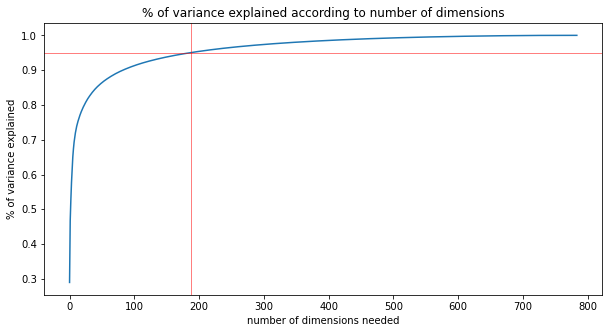

In [45]:
plt.figure(figsize = [10,5])
plt.plot(cumsum)
plt.ylabel("% of variance explained")
plt.xlabel("number of dimensions needed")
plt.title("% of variance explained according to number of dimensions");
plt.axhline(y=0.95, linewidth=0.5, color='r');
plt.axvline(x=187, linewidth=0.5, color='r');

lets aim for 95% of the variance

In [46]:
pca = PCA(n_components = 0.95)
data_reduced = pca.fit_transform(data_train)
test_reduced = pca.transform(data_test)
data_recoverd = pca.inverse_transform(data_reduced)
test_recoverd = pca.inverse_transform(test_reduced)

In [47]:
data_reduced.shape

(57000, 187)

As we can see we only need 187 dimensions to explain 95% of the variance, lets see how an image looks after we redcued the data and recoverd it

In [57]:
data_recoverd_to_show = data_recoverd.reshape(-1,28,28,1)

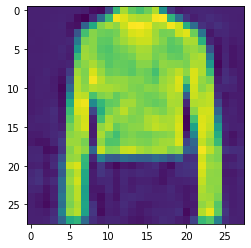

In [58]:
plt.imshow(data_recoverd_to_show[420]);

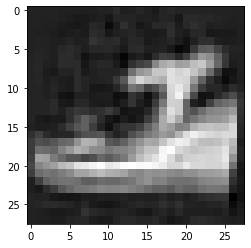

In [59]:
plt.imshow(data_recoverd_to_show[69],cmap = plt.get_cmap("gray"))

Now lets try training week learners on the data after PCA

In [61]:
knn = KNeighborsClassifier()
n_range = np.arange(100,1001,100)
scores = []
for n in n_range:
    knn.n_neighbors = n
    knn.fit(data_reduced,target_train)
    pred = knn.predict(test_reduced)
    scores.append(metrics.accuracy_score(target_test,pred))

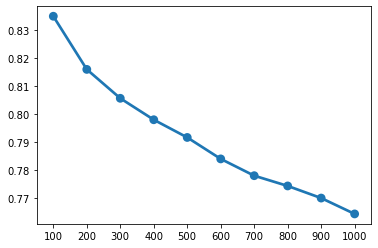

In [62]:
sns.pointplot(x = n_range, y = scores);

as we can see after the pca it is also the best with only 100 neighbors

In [63]:
knn_after = KNeighborsClassifier(n_neighbors = 100)
gnb_clf = GaussianNB()
LoR_clf = LogisticRegression(random_state=0)
RF_clf = RandomForestClassifier(n_estimators=150, random_state=1)
dtclf = DecisionTreeClassifier(random_state=0, max_depth = 3)
soft_voter = VotingClassifier(estimators = [('knn_after',knn_after),('lr',LoR_clf),('decision_tree',dtclf),('gaussian_bayes',gnb_clf),('random_forsts',RF_clf)],n_jobs = -1,voting='soft')
hard_voter = VotingClassifier(estimators = [('knn_after',knn_after),('lr',LoR_clf),('decision_tree',dtclf),('gaussian_bayes',gnb_clf),('random_forsts',RF_clf)],n_jobs = -1,voting='hard')

In [64]:
for clf in (knn_after,gnb_clf,LoR_clf,RF_clf,dtclf,soft_voter,hard_voter):
    start_time = time.time()
    clf.fit(data_reduced,target_train)
    time_to_train = time.time()- start_time
    pred = clf.predict(test_reduced)
    score = metrics.accuracy_score(target_test,pred)
    after_pca_scores.append(score)
    time_after_pca.append(time_to_train)
    print(clf.__class__.__name__ + " score is: %.3f " %(score) + ", time to train: %.2f seconds" %(time_to_train))

KNeighborsClassifier score is: 0.835 , time to train: 4.27 seconds
GaussianNB score is: 0.745 , time to train: 0.28 seconds
LogisticRegression score is: 0.852 , time to train: 8.57 seconds
RandomForestClassifier score is: 0.869 , time to train: 161.49 seconds
DecisionTreeClassifier score is: 0.481 , time to train: 4.90 seconds
VotingClassifier score is: 0.847 , time to train: 166.55 seconds
VotingClassifier score is: 0.859 , time to train: 164.07 seconds


Now lets the take to Logistic regression again as it is the one with the highest accuracy and use bagging on him

In [67]:
n_range = np.arange(10,51,10)
bag_scores = []
for n in n_range:
    Bagg_clf = BaggingClassifier(base_estimator= LoR_clf, n_estimators= n)
    Bagg_clf.fit(data_reduced, target_train)
    pred = Bagg_clf.predict(test_reduced)
    bag_scores.append(metrics.accuracy_score(target_test,pred))

<AxesSubplot:>

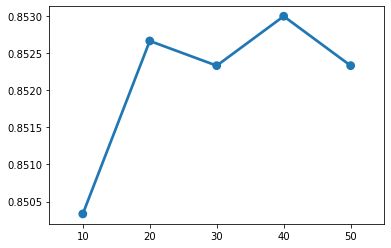

In [68]:
sns.pointplot(x = n_range, y = bag_scores)

as we can see we need 40 classifiers for the highest score

In [70]:
start_time = time.time()
Bagg_clf_after = BaggingClassifier(base_estimator= LoR_clf, n_estimators= 40)
Bagg_clf_after.fit(data_reduced, target_train)
time_to_train = time.time() - start_time
pred = Bagg_clf_after.predict(test_reduced)
score = (metrics.accuracy_score(target_test,pred))
after_pca_scores.append(score)
time_after_pca.append(time_to_train)
print(Bagg_clf_after.__class__.__name__ + " score is: %.3f " %(score) + ", time to train: %.2f seconds" %(time_to_train))

BaggingClassifier score is: 0.851 , time to train: 324.78 seconds


Next lets move on to Boosting, and at first, adaBoost

In [74]:
start_time = time.time()
adaBoost_after = AdaBoostClassifier(n_estimators = 200, learning_rate = 0.5)
adaBoost_after.fit(data_reduced,target_train)
time_to_train = time.time()- start_time
pred = adaBoost_after.predict(test_reduced)
score = metrics.accuracy_score(target_test,pred)
name = adaBoost_after.__class__.__name__
print(name + " score is: %.3f " %(score) + ", time to train: %.2f seconds" %(time_to_train))

AdaBoostClassifier score is: 0.552 , time to train: 360.04 seconds


as we can see, we got better results, and with less training time then the previous adaBoost classifier, now lets move on to gradient boosting

In [77]:
start_time = time.time()
gBoost_after = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.5, max_depth = 3)
gBoost_after.fit(data_reduced,target_train)
time_to_train = time.time()- start_time
pred = gBoost_after.predict(test_reduced)
score = metrics.accuracy_score(target_test,pred)
name = gBoost_after.__class__.__name__
print(name + " score is: %.3f " %(score) + ", time to train: %.2f seconds" %(time_to_train))

GradientBoostingClassifier score is: 0.856 , time to train: 8811.64 seconds


After several tries, I got pretty good accuracy from Gradient boosting but it took very long to train, now lets try XGBoost

In [142]:
start_time = time.time()
xgb_after = xgboost.XGBClassifier(n_estimators = 150,eval_metric = "merror",learning_rate = 0.25)
xgb_after.fit(data_reduced, target_train)
pred = xgb_after.predict(test_reduced)
print(metrics.accuracy_score(target_test,pred))
print("time to calculate %.2f" %(time.time()-start_time))

0.89
time to calculate 689.00


after running all the models nad ensemble methods, lets some it up in a graph and get to our conclusion

In [103]:
i = 0
#scale to minutes and full precenteges
for i in range(11):
    time_before_pca[i] = time_before_pca[i]/60
    time_after_pca[i] = time_after_pca[i]/60
    after_pca_scores[i] = after_pca_scores[i]*100
    before_pca_scores[i] = before_pca_scores[i]*100

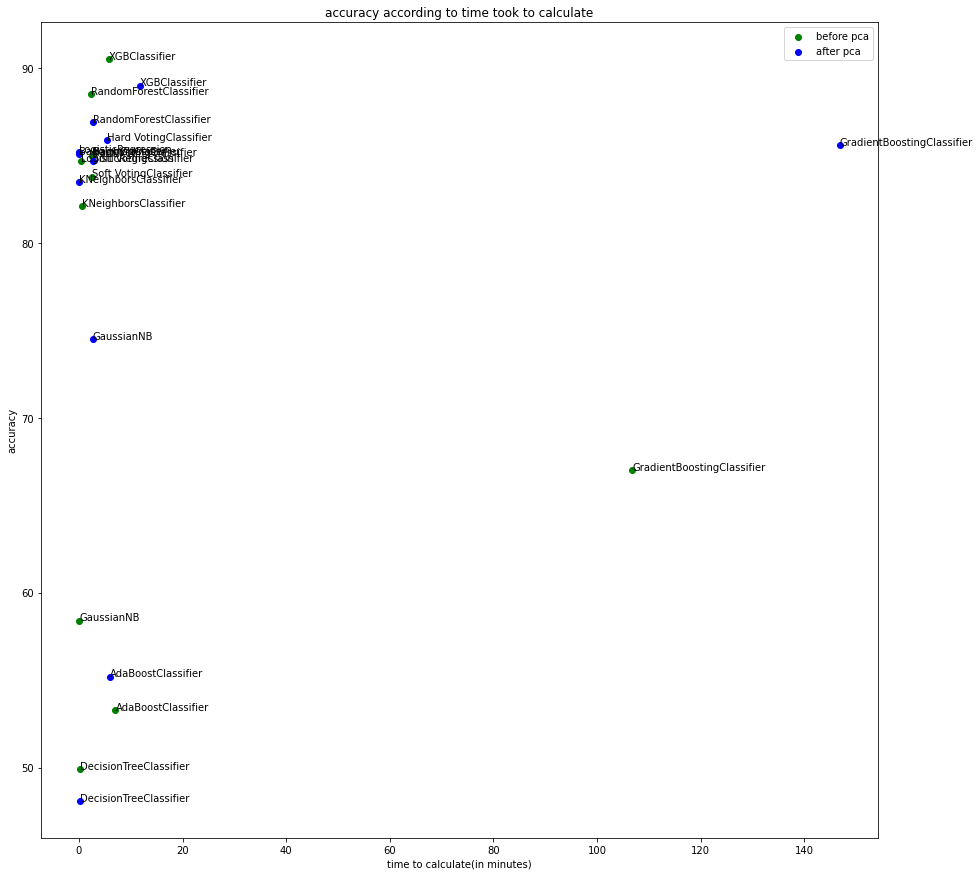

In [122]:
fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(time_before_pca, before_pca_scores, c='green', label = "before pca")
for i, txt in enumerate(model_names):
    ax.annotate(txt, (time_before_pca[i], before_pca_scores[i]))
    
ax.scatter(time_after_pca, after_pca_scores,c='blue', label = "after pca")

for i, txt in enumerate(model_names):
    ax.annotate(txt, (time_after_pca[i], after_pca_scores[i]))
    
plt.ylabel("accuracy")
plt.xlabel("time to calculate(in minutes)")
plt.title("accuracy according to time took to calculate");
plt.legend()

From what we can see, our top model was the XGboost classifier from before we used the pca, and the second after is the same one after the pca, and the last step is to check the accuracy on the test files

In [123]:
test_df = pd.read_csv("D:\\ML_SEM2\\fashion-mnist_test.csv")

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
test_labels = test_df.label.values
test_data = test_df.drop(['label'],axis = 1).values

In [139]:
test_data_reduced = pca.transform(test_data)

In [143]:
pred = xgb_after.predict(test_data_reduced)
print("the final score for xgb after pca is " + str(metrics.accuracy_score(test_labels,pred)*100))

the final score for xgb after pca is 88.64


In [144]:
pred = xgb_before.predict(test_data)
print("the final score for xgb after pca is " + str(metrics.accuracy_score(test_labels,pred)*100))

the final score for xgb after pca is 90.82000000000001


# Conclusion <a id='conclusion'></a>

As we can see, our final and best score was 90.8% with the XGBoost classifier from before using PCa

In this notebook, the data itself was already pretty clean, there wasnt much preprocessing needed. After I got the data I wanted to know how it looks like before and after the reduction of dimensions. 

I also wanted to see how each ensemble method prefomred in this task.